In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

In [3]:
image = tf.Variable(tf.zeros((299, 299, 3)))

In [4]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignore background class
        probs = tf.nn.softmax(logits) # probabilities
    return logits, probs

logits, probs = inception(image, reuse=False) #false

In [5]:
#Next, we load pre-trained weights. This Inception v3 has a top-5 accuracy of 93.9%.
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [6]:
data_dir = tempfile.mkdtemp()
# inception_tarball, _ = urlretrieve('http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarPath  = "inception_v3_2016_08_28.tar.gz"
tarfile.open(tarPath, 'r:gz').extractall(data_dir)

In [7]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

In [8]:
#Next, we write some code to show an image, classify it, and show the classification result.
import json
import matplotlib.pyplot as plt

In [9]:
# imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [10]:
def classify(img, correct_class=None, target_class=None):
#     print(correct_class, target_class)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)

    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [11]:
import PIL
import numpy as np

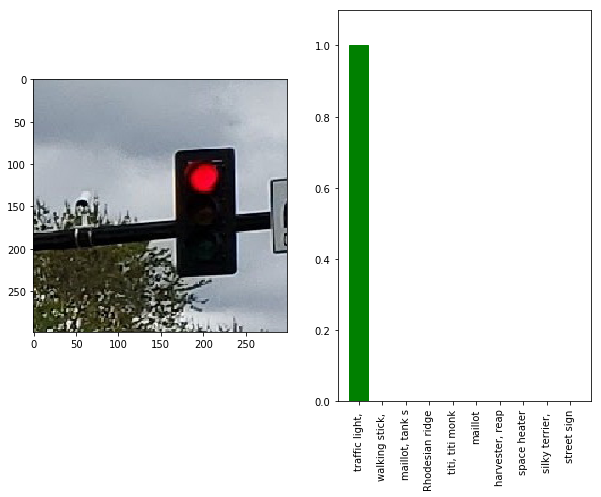

In [12]:
#classification done
img_class = 920
img_path = "test_data/20190420_145352_010_resize.jpg"
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img1 = (np.asarray(img) / 255.0).astype(np.float32)
classify(img1, correct_class=img_class)

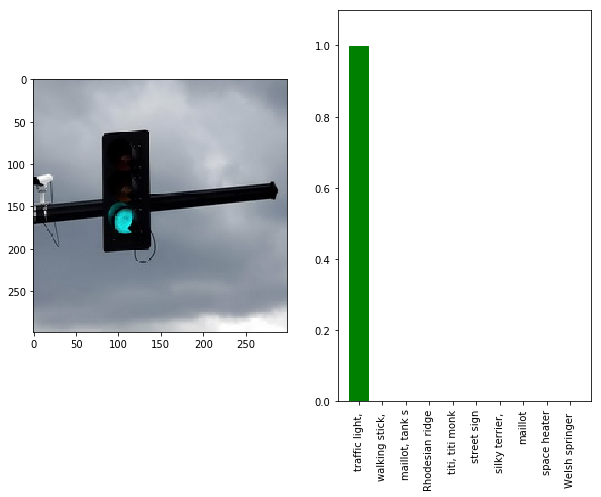

In [13]:
#classification done
img_class = 920
img_path = "test_data/20190420_145521_009_resize.jpg"
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img2 = (np.asarray(img) / 255.0).astype(np.float32)
classify(img2, correct_class=img_class)

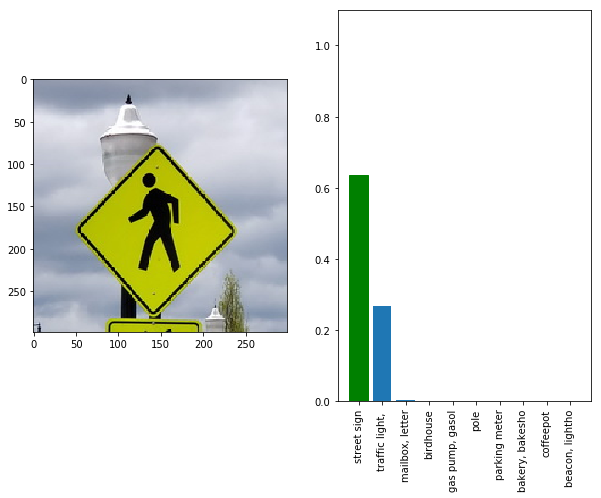

In [14]:
#classification done
img_class = 919
img_path = "test_data/20190420_145828_001_resize.jpg"
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img3 = (np.asarray(img) / 255.0).astype(np.float32)
classify(img3, correct_class=img_class)

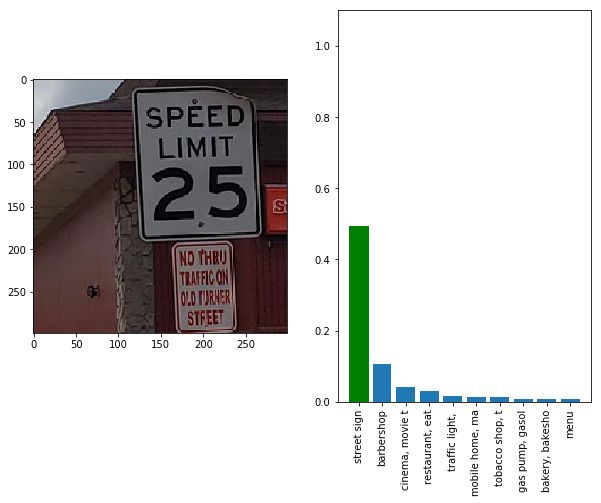

In [15]:
#classification done
img_class = 919
img_path = "test_data/20190420_152106_049_resize.jpg"
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img4 = (np.asarray(img) / 255.0).astype(np.float32)
classify(img4, correct_class=img_class)

In [16]:
##########################
#### Begin Attack ########
##########################

In [17]:
#We start with the easiest part: writing a TensorFlow op for initialization.
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

In [18]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

In [19]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [20]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 920 # traffic signal
demo_target = 919 # street sign
threshold = 0.001

In [21]:
# initialization step
sess.run(assign_op, feed_dict={x: img1})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img1, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break
    
adv1 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.00254034
step 20, loss=0.00103087


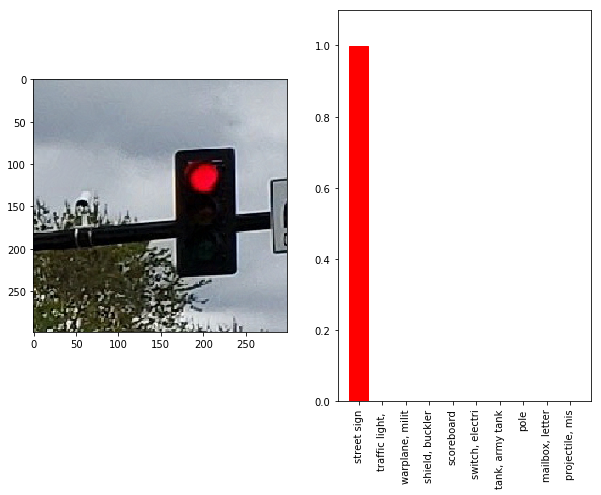

In [22]:
classify(adv1, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


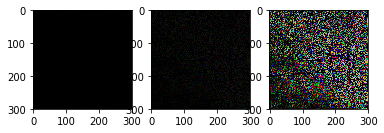

In [23]:
#calculate perturbation 

# print(img.shape)
# print(adv.shape)
div1 = (img1-adv1)
# print(div.shape)

plt.subplot(131)
plt.imshow(div1*1)

plt.subplot(132)
plt.imshow(div1*10)

plt.subplot(133)
plt.imshow(div1*100)
plt.show()

In [24]:
from skimage.measure import compare_ssim as ssim

ssim_val = ssim(img1, adv1, 255, multichannel=True)
print(ssim_val)

l2_dist = np.sqrt(np.sum((div1)**2))/np.sqrt(np.sum((img1)**2))
print(l2_dist)

0.9998495094993248
0.00880784


In [25]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 920 # traffic signal
demo_target = 919 # street sign
threshold = 0.001

In [26]:
# initialization step
sess.run(assign_op, feed_dict={x: img2})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img2, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break

adv2 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.000884261


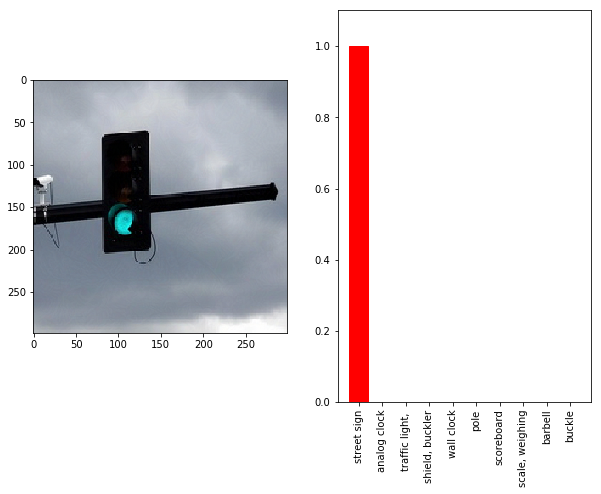

In [27]:
classify(adv2, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


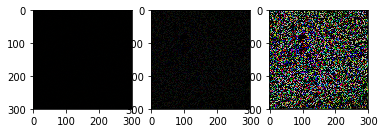

In [28]:
#calculate perturbation 
div2 = (img2-adv2)

plt.subplot(131)
plt.imshow(div2*1)

plt.subplot(132)
plt.imshow(div2*10)

plt.subplot(133)
plt.imshow(div2*100)
plt.show()

In [29]:
ssim_val = ssim(img2, adv2, 255, multichannel=True)
print(ssim_val)

l2_dist = np.sqrt(np.sum((div2)**2))/np.sqrt(np.sum((img2)**2))
print(l2_dist)

0.9997765541958251
0.008407084


In [30]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 919 # street sign
demo_target = 920 # traffic signal
threshold = 0.001

In [31]:
# initialization step
sess.run(assign_op, feed_dict={x: img3})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img3, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break

adv3 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.00251168
step 20, loss=0.0013858


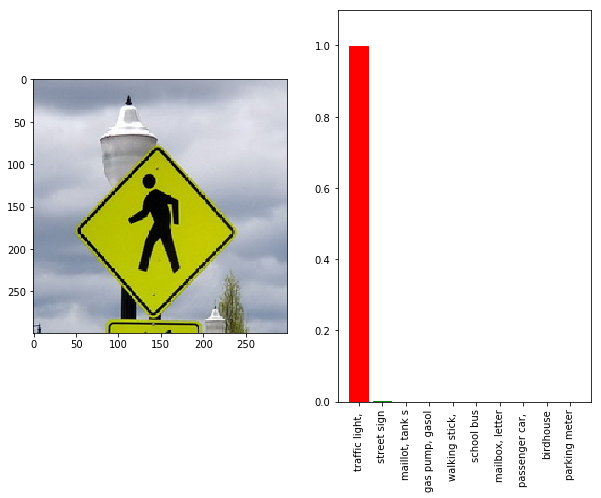

In [32]:
classify(adv3, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


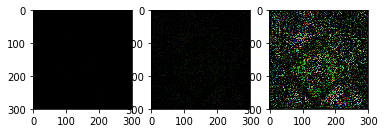

In [35]:
#calculate perturbation 
div3 = (img3-adv3)

plt.subplot(131)
plt.imshow(div3*1)

plt.subplot(132)
plt.imshow(div3*10)

plt.subplot(133)
plt.imshow(div3*100)
plt.show()

In [36]:
ssim_val = ssim(img3, adv3, 255, multichannel=True)
print(ssim_val)

l2_dist = np.sqrt(np.sum((div3)**2))/np.sqrt(np.sum((img3)**2))
print(l2_dist)

0.9999084733377125
0.004243828


In [37]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 919 # street sign
demo_target = 920 # traffic signal
threshold = 0.001

In [38]:
# initialization step
sess.run(assign_op, feed_dict={x: img4})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img4, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break

adv4 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.00245627
step 20, loss=0.0012583


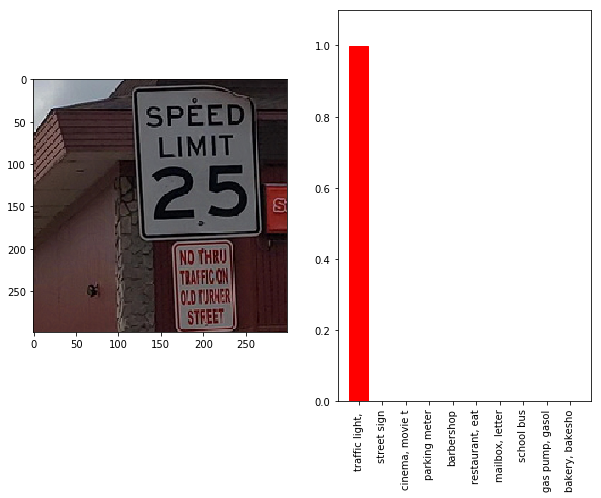

In [39]:
classify(adv4, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


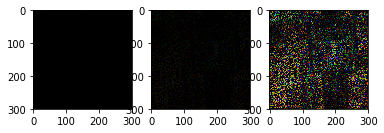

In [40]:
#calculate perturbation 
div4 = (img4-adv4)

plt.subplot(131)
plt.imshow(div4*1)

plt.subplot(132)
plt.imshow(div4*10)

plt.subplot(133)
plt.imshow(div4*100)
plt.show()

In [41]:
ssim_val = ssim(img4, adv4, 255, multichannel=True)
print(ssim_val)

l2_dist = np.sqrt(np.sum((div4)**2))/np.sqrt(np.sum((img4)**2))
print(l2_dist)

0.9997604196595073
0.010773257


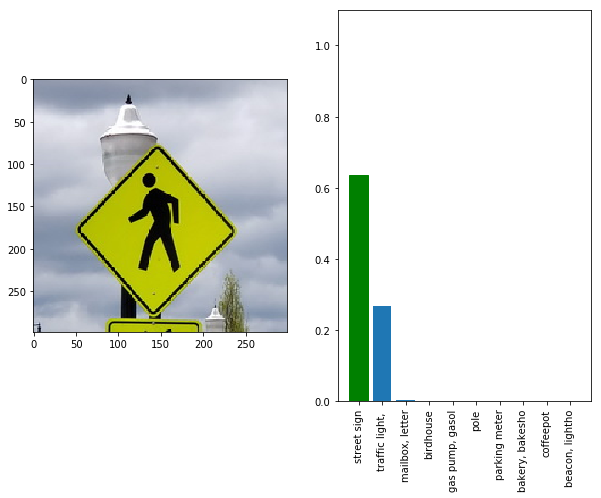

In [42]:
#classification done
img_class = 919
img_path = "test_data/20190420_145828_001_resize.jpg"
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img3 = (np.asarray(img) / 255.0).astype(np.float32)
classify(img3, correct_class=img_class)

(299, 299, 3)


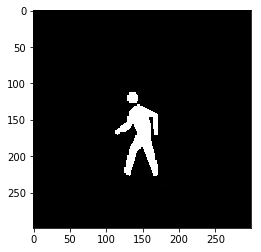

In [50]:
########################################################
# print(image, type(image), image.size)
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
mask = Image.open('test_data/mask_20190420_145828_001_resize.jpg')
big_dim = max(mask.width, mask.height)
#print(mask.width, " , ", mask.height)
wide = mask.width > mask.height
new_w = 299 if not wide else int(mask.width * 299 / mask.height)
new_h = 299 if wide else int(mask.height * 299 / mask.width)
mask = mask.resize((new_w, new_h)).crop((0, 0, 299, 299))
mask = (np.asarray(mask)/255.0).astype(np.float32)

print(mask.shape)

for indx1 in range(mask.shape[0]):
    for indx2 in range(mask.shape[1]):
        if(mask[indx1][indx2][0] > 10 or mask[indx1][indx2][1] > 10 or mask[indx1][indx2][2] > 10):
            mask[indx1][indx2][0] = 1
            mask[indx1][indx2][1] = 1
            mask[indx1][indx2][2] = 1
plt.imshow(mask)
plt.show()

# print(mask)
# mask = mask.transpose()
########################################################

In [51]:
epsilon = tf.placeholder(tf.float32, ())

below = x - (mask*epsilon)
above = x + (mask*epsilon)
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [53]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 919 # street sign
demo_target = 920 # traffic signal
threshold = 0.001

In [54]:
# initialization step
sess.run(assign_op, feed_dict={x: img3})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img3, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break

adv5 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.426157
step 20, loss=0.328863
step 30, loss=0.318015
step 40, loss=0.29287
step 50, loss=0.284711
step 60, loss=0.279949
step 70, loss=0.301997
step 80, loss=0.290358
step 90, loss=0.283339
step 100, loss=0.282034
step 110, loss=0.288864
step 120, loss=0.289906
step 130, loss=0.31051
step 140, loss=0.277823
step 150, loss=0.303996
step 160, loss=0.295895
step 170, loss=0.286388
step 180, loss=0.276492
step 190, loss=0.276642
step 200, loss=0.281594
step 210, loss=0.27009
step 220, loss=0.26936
step 230, loss=0.258655
step 240, loss=0.277509
step 250, loss=0.259085
step 260, loss=0.308243
step 270, loss=0.299197
step 280, loss=0.291622
step 290, loss=0.277945
step 300, loss=0.296036
step 310, loss=0.256852
step 320, loss=0.285701
step 330, loss=0.275106
step 340, loss=0.265216
step 350, loss=0.267376
step 360, loss=0.284673
step 370, loss=0.258844
step 380, loss=0.280048
step 390, loss=0.278099
step 400, loss=0.310438
step 410, loss=0.286325
step 420, loss=0.272593
step 

KeyboardInterrupt: 

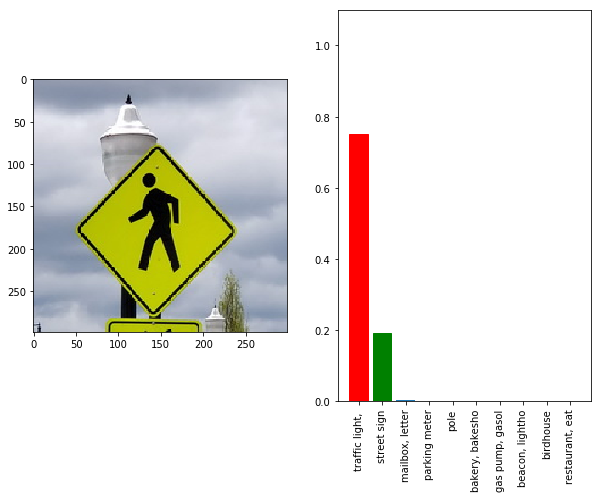

In [47]:
classify(adv5, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


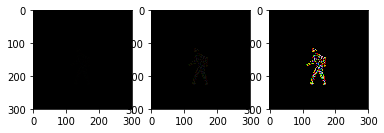

In [48]:
#calculate perturbation 
div5 = (img3-adv5)

plt.subplot(131)
plt.imshow(div5*1)

plt.subplot(132)
plt.imshow(div5*10)

plt.subplot(133)
plt.imshow(div5*100)
plt.show()

In [49]:
ssim_val = ssim(img3, adv5, 255, multichannel=True)
print(ssim_val)

l2_dist = np.sqrt(np.sum((div5)**2))/np.sqrt(np.sum((img3)**2))
print(l2_dist)


0.9999804034981583
0.001796253


(299, 299, 3)


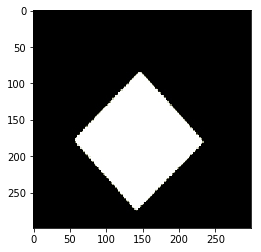

In [60]:
########################################################
# print(image, type(image), image.size)
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
mask = Image.open('test_data/signMask/mask2_20190420_145828_001_resize.jpg')
big_dim = max(mask.width, mask.height)
#print(mask.width, " , ", mask.height)
wide = mask.width > mask.height
new_w = 299 if not wide else int(mask.width * 299 / mask.height)
new_h = 299 if wide else int(mask.height * 299 / mask.width)
mask = mask.resize((new_w, new_h)).crop((0, 0, 299, 299))
mask = (np.asarray(mask)/255.0).astype(np.float32)

print(mask.shape)

for indx1 in range(mask.shape[0]):
    for indx2 in range(mask.shape[1]):
        if(mask[indx1][indx2][0] > 10 or mask[indx1][indx2][1] > 10 or mask[indx1][indx2][2] > 10):
            mask[indx1][indx2][0] = 1
            mask[indx1][indx2][1] = 1
            mask[indx1][indx2][2] = 1
plt.imshow(mask)
plt.show()

# print(mask)
# mask = mask.transpose()
########################################################

In [61]:
epsilon = tf.placeholder(tf.float32, ())

below = x - (mask*epsilon)
above = x + (mask*epsilon)
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [62]:
demo_epsilon = 2.0/255.0 # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
img_class = 919 # street sign
demo_target = 920 # traffic signal
threshold = 0.001

In [63]:
# initialization step
sess.run(assign_op, feed_dict={x: img3})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img3, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break

adv6 = x_hat.eval() # retrieve the adversarial example

step 10, loss=0.0221531
step 20, loss=0.0139038
step 30, loss=0.0109037
step 40, loss=0.00908349
step 50, loss=0.00790125
step 60, loss=0.00705028
step 70, loss=0.00640009
step 80, loss=0.00590082
step 90, loss=0.00549568
step 100, loss=0.00515809


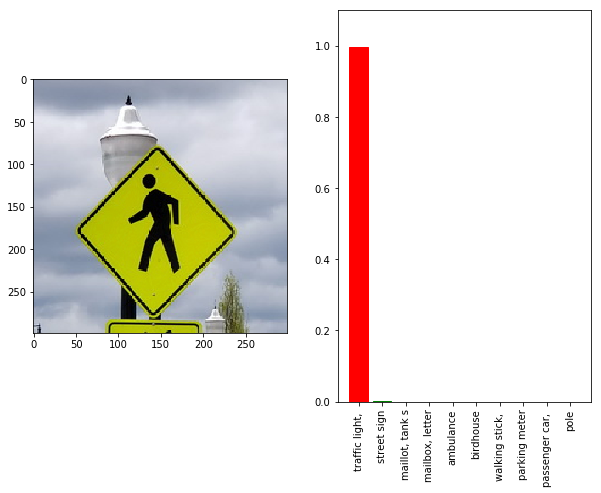

In [64]:
classify(adv6, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


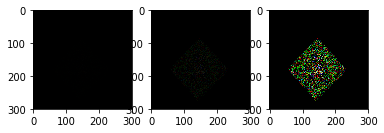

In [65]:
#calculate perturbation 
div6 = (img3-adv6)

plt.subplot(131)
plt.imshow(div6*1)

plt.subplot(132)
plt.imshow(div6*10)

plt.subplot(133)
plt.imshow(div6*100)
plt.show()

In [67]:
ssim_val = ssim(img3, adv6, 255, multichannel=True)
print("SSIM: ", ssim_val)

l2_dist = np.sqrt(np.sum((div6)**2))/np.sqrt(np.sum((img3)**2))
print("L2: ",l2_dist)

SSIM:  0.9999567617888235
L2:  0.0025935797


In [80]:
signImages = ["test_data/signMask/20190420_145828_001_resize.jpg",
              "test_data/signMask/20190420_145828_010_resize.jpg",
              "test_data/signMask/20190420_145828_022_resize.jpg",
              "test_data/signMask/20190420_145828_025_resize.jpg",
              "test_data/signMask/20190420_145828_031_resize.jpg",
              "test_data/signMask/20190420_145828_033_resize.jpg",
              "test_data/signMask/20190420_145828_047_resize.jpg",
              "test_data/signMask/20190420_145828_049_resize.jpg",
              "test_data/signMask/20190420_145828_061_resize.jpg",              
              "test_data/signMask/20190420_145828_064_resize.jpg"]

maskImages = ["test_data/signMask/mask_20190420_145828_001_resize.jpg",
              "test_data/signMask/mask_20190420_145828_010_resize.jpg",
              "test_data/signMask/mask_20190420_145828_022_resize.jpg",
              "test_data/signMask/mask_20190420_145828_025_resize.jpg",
              "test_data/signMask/mask_20190420_145828_031_resize.jpg",
              "test_data/signMask/mask_20190420_145828_033_resize.jpg",
              "test_data/signMask/mask_20190420_145828_047_resize.jpg",
              "test_data/signMask/mask_20190420_145828_049_resize.jpg",
              "test_data/signMask/mask_20190420_145828_061_resize.jpg",              
              "test_data/signMask/mask_20190420_145828_064_resize.jpg"]

In [88]:
for i in range(10):
    print(maskImages[i])

test_data/signMask/mask_20190420_145828_001_resize.jpg
test_data/signMask/mask_20190420_145828_010_resize.jpg
test_data/signMask/mask_20190420_145828_022_resize.jpg
test_data/signMask/mask_20190420_145828_025_resize.jpg
test_data/signMask/mask_20190420_145828_031_resize.jpg
test_data/signMask/mask_20190420_145828_033_resize.jpg
test_data/signMask/mask_20190420_145828_047_resize.jpg
test_data/signMask/mask_20190420_145828_049_resize.jpg
test_data/signMask/mask_20190420_145828_061_resize.jpg
test_data/signMask/mask_20190420_145828_064_resize.jpg


step 10, loss=0.343714
step 20, loss=0.330891


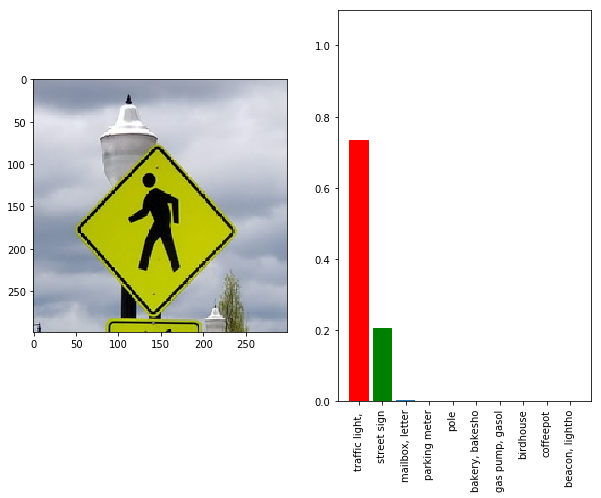

SSIM:  0.9999829381412707
L2:  0.001669526


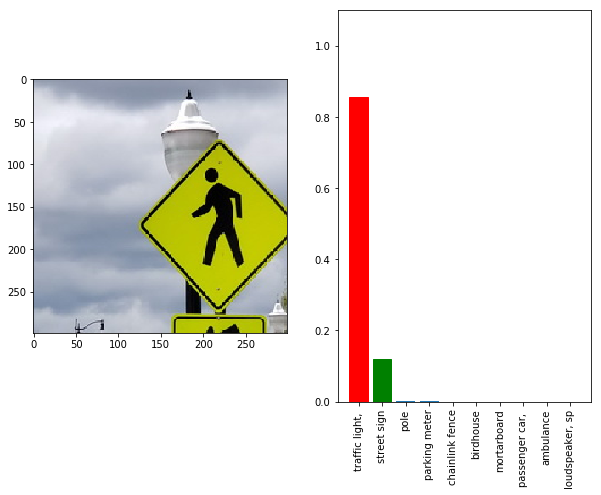

SSIM:  0.9999973323952993
L2:  0.0006237688


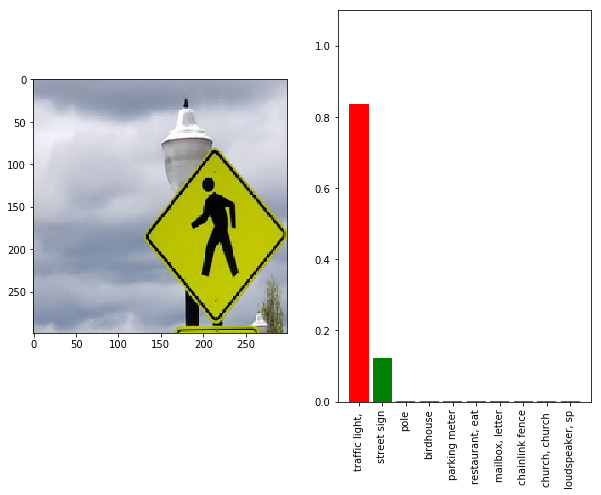

SSIM:  0.9999930108836783
L2:  0.000978272
step 10, loss=0.297091


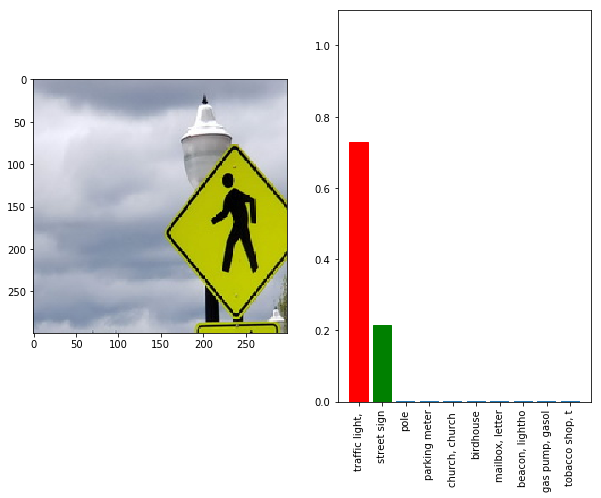

SSIM:  0.9999876188009066
L2:  0.0013061152


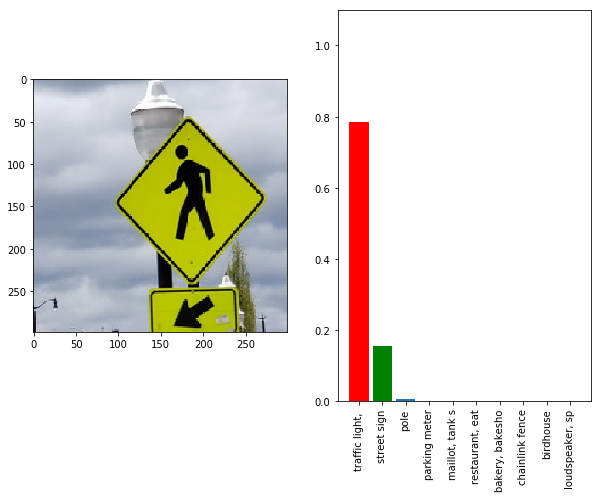

SSIM:  0.9999911158021293
L2:  0.001203018


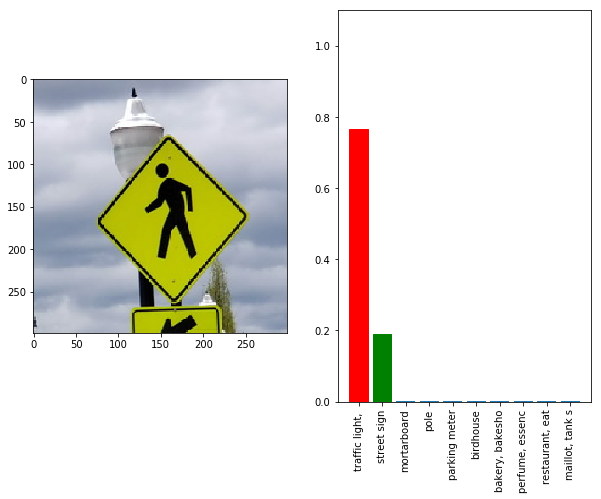

SSIM:  0.9999876687086529
L2:  0.0014012083


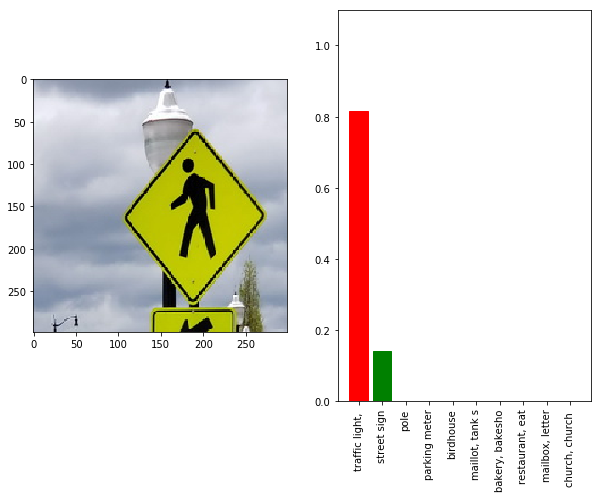

SSIM:  0.9999947599954587
L2:  0.00088185683


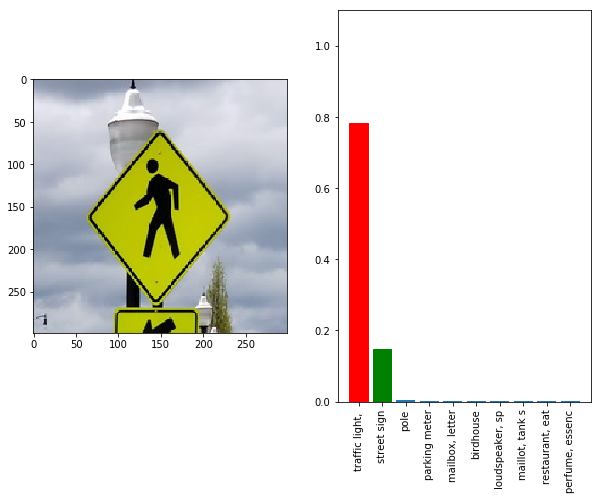

SSIM:  0.999992791988524
L2:  0.0010332094


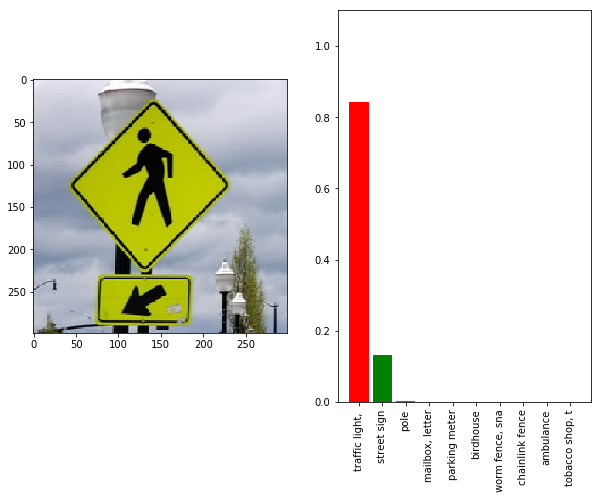

SSIM:  0.9999928029222628
L2:  0.0011338189
step 10, loss=0.472205
step 20, loss=0.397114
step 30, loss=0.41561
step 40, loss=0.383753
step 50, loss=0.358428
step 60, loss=0.351189
step 70, loss=0.356374
step 80, loss=0.345665
step 90, loss=0.362119
step 100, loss=0.340735


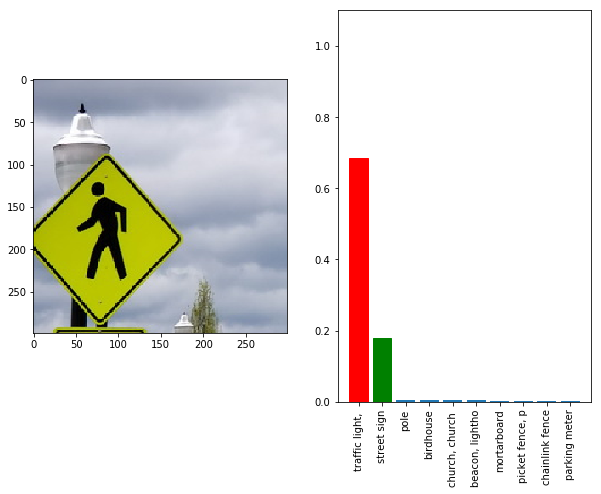

SSIM:  0.9999806277087123
L2:  0.0016875778


In [89]:
########################################################
for i in range(10):
    
    # img_path = 'test_data/signMask/20190420_145828_001_resize.jpg'
    img_path = signImages[i]

    
    img = PIL.Image.open(img_path)
    big_dim = max(img.width, img.height)
    wide = img.width > img.height
    new_w = 299 if not wide else int(img.width * 299 / img.height)
    new_h = 299 if wide else int(img.height * 299 / img.width)
    img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
    imgX = (np.asarray(img) / 255.0).astype(np.float32)


    # mask = Image.open('test_data/signMask/mask_20190420_145828_001_resize.jpg')
    mask = Image.open(maskImages[i])

    big_dim = max(mask.width, mask.height)
    #print(mask.width, " , ", mask.height)
    wide = mask.width > mask.height
    new_w = 299 if not wide else int(mask.width * 299 / mask.height)
    new_h = 299 if wide else int(mask.height * 299 / mask.width)
    mask = mask.resize((new_w, new_h)).crop((0, 0, 299, 299))
    mask = (np.asarray(mask)/255.0).astype(np.float32)

    for indx1 in range(mask.shape[0]):
        for indx2 in range(mask.shape[1]):
            if(mask[indx1][indx2][0] > 10 or mask[indx1][indx2][1] > 10 or mask[indx1][indx2][2] > 10):
                mask[indx1][indx2][0] = 1
                mask[indx1][indx2][1] = 1
                mask[indx1][indx2][2] = 1

    epsilon = tf.placeholder(tf.float32, ())

    below = x - (mask*epsilon)
    above = x + (mask*epsilon)
    projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
    with tf.control_dependencies([projected]):
        project_step = tf.assign(x_hat, projected)

    demo_epsilon = 2.0/255.0 # a really small perturbation
    demo_lr = 1e-1
    demo_steps = 100
    img_class = 919 # street sign
    demo_target = 920 # traffic signal
    threshold = 0.3 # 0.001

    # initialization step
    sess.run(assign_op, feed_dict={x: imgX})

    # projected gradient descent
    for i in range(demo_steps):
        # gradient descent step
        _, loss_value = sess.run(
            [optim_step, loss],
            feed_dict={learning_rate: demo_lr, y_hat: demo_target})
        # project step
        sess.run(project_step, feed_dict={x: imgX, epsilon: demo_epsilon})
        if (i+1) % 10 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))
        if loss_value < threshold:
            break

    advX = x_hat.eval() # retrieve the adversarial example

    classify(advX, correct_class=img_class, target_class=demo_target)

    #calculate perturbation 
    divX = (imgX-advX)

    ssim_val = ssim(imgX, advX, 255, multichannel=True)
    print("SSIM: ", ssim_val)

    l2_dist = np.sqrt(np.sum((divX)**2))/np.sqrt(np.sum((imgX)**2))
    print("L2: ",l2_dist)

########################################################

(299, 299, 3)


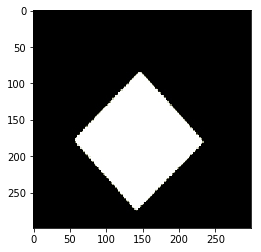

In [95]:
########################################################
# print(image, type(image), image.size)
import PIL
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
mask = Image.open('test_data/signMask/mask2_20190420_145828_001_resize.jpg')
big_dim = max(mask.width, mask.height)
#print(mask.width, " , ", mask.height)
wide = mask.width > mask.height
new_w = 299 if not wide else int(mask.width * 299 / mask.height)
new_h = 299 if wide else int(mask.height * 299 / mask.width)
mask = mask.resize((new_w, new_h)).crop((0, 0, 299, 299))
mask = (np.asarray(mask)/255.0).astype(np.float32)

print(mask.shape)

for indx1 in range(mask.shape[0]):
    for indx2 in range(mask.shape[1]):
        if(mask[indx1][indx2][0] > 10 or mask[indx1][indx2][1] > 10 or mask[indx1][indx2][2] > 10):
            mask[indx1][indx2][0] = 1
            mask[indx1][indx2][1] = 1
            mask[indx1][indx2][2] = 1
plt.imshow(mask)
plt.show()

# print(mask)
# mask = mask.transpose()
########################################################

In [96]:
##########################
### Robust Attack ########
##########################

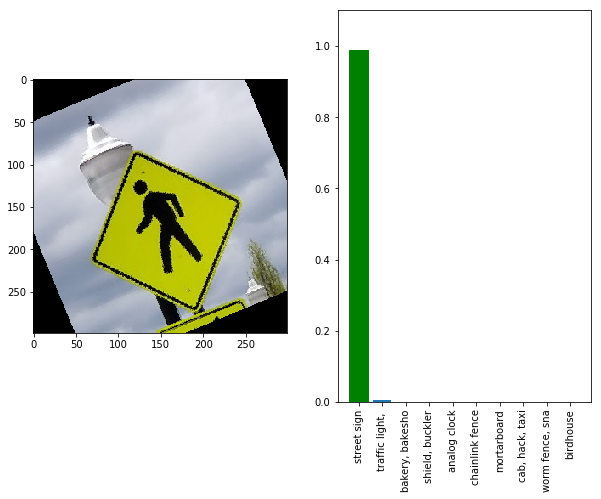

In [97]:
#############The following takes long time to execute
#Robust adversarial examples

ex_angle = np.pi/8

angle = tf.placeholder(tf.float32, ())
rotated_image = tf.contrib.image.rotate(img3, angle)
rotated_example = rotated_image.eval(feed_dict={image: adv4, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

In [102]:
num_samples = 10
average_loss = 0
for i in range(num_samples):
    rotated = tf.contrib.image.rotate(
        image, tf.random_uniform((), minval=-np.pi/4, maxval=np.pi/4))
    rotated_logits, _ = inception(rotated, reuse=True)
    average_loss += tf.nn.softmax_cross_entropy_with_logits(
        logits=rotated_logits, labels=labels) / num_samples

In [103]:
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(average_loss, var_list=[x_hat])

In [104]:
# epsilon = tf.placeholder(tf.float32, ())

# below = x - (mask*epsilon)
# above = x + (mask*epsilon)
# projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
# with tf.control_dependencies([projected]):
#     project_step = tf.assign(x_hat, projected)

In [106]:
demo_epsilon = 20.0/255.0 # still a pretty small perturbation
demo_lr = 2e-1
demo_steps = 50 #300
demo_target = 920 # traffic light
threshold = 0.3

# initialization step
sess.run(assign_op, feed_dict={x: img3})

# projected gradient descent
for i in range(demo_steps):
    # gradient descent step
    _, loss_value = sess.run(
        [optim_step, average_loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # project step
    sess.run(project_step, feed_dict={x: img3, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    if loss_value < threshold:
        break
    

adv_robust = x_hat.eval() # retrieve the adversarial example

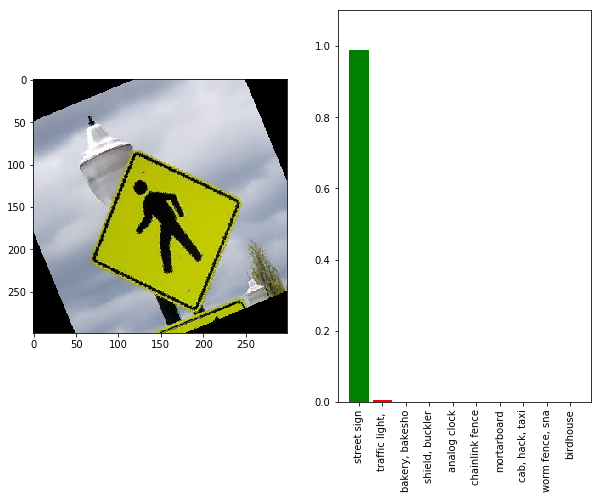

In [107]:
rotated_example = rotated_image.eval(feed_dict={image: adv_robust, angle: ex_angle})
classify(rotated_example, correct_class=img_class, target_class=demo_target)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(299, 299, 3)
(299, 299, 3)
(299, 299, 3)


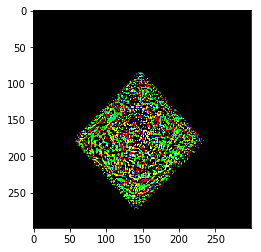

In [108]:
#calculate perturbation 

print(img3.shape)
print(adv_robust.shape)

# div2 = img3-rotated_example
div2 = img3-adv_robust
print(div2.shape)

plt.imshow(div2*100)
plt.show()

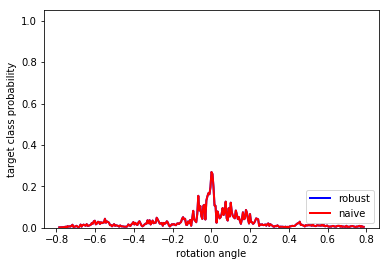

In [109]:
#Evaluation
thetas = np.linspace(-np.pi/4, np.pi/4, 301)

p_naive = []
p_robust = []
for theta in thetas:
    rotated = rotated_image.eval(feed_dict={image: adv_robust, angle: theta})
    p_robust.append(probs.eval(feed_dict={image: rotated})[0][demo_target])
    
    rotated = rotated_image.eval(feed_dict={image: adv4, angle: theta})
    p_naive.append(probs.eval(feed_dict={image: rotated})[0][demo_target])

robust_line, = plt.plot(thetas, p_robust, color='b', linewidth=2, label='robust')
naive_line, = plt.plot(thetas, p_naive, color='r', linewidth=2, label='naive')
plt.ylim([0, 1.05])
plt.xlabel('rotation angle')
plt.ylabel('target class probability')
plt.legend(handles=[robust_line, naive_line], loc='lower right')
plt.show()